In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
#from bayes_opt import BayesianOptimization
import warnings

In [2]:
histFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\historical_transactions.csv\historical_transactions.csv"
merchFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\merchants.csv\merchants.csv"
newMerchFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\merchant_transactions.csv"
testFilePath = 'E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\est.csv'
trainFilePath = "E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\in.csv"

In [3]:
#newMerchFilePath1 = 'E:\Data Science\SpringBoard DS\Capstone Project 2\Dataset\Elo Market Recommendation\merchant_transactions.csv'

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
pd.set_option('display.max_columns', 100)

In [6]:
def imputeNaN(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].fillna('other')
        elif df[column].dtype == 'int8' or df[column].dtype == 'int16' or df[column].dtype == 'int32' or df[column].dtype == 'int64' or df[column].dtype == 'float16' or df[column].dtype == 'float32' or df[column].dtype == 'float64':
            df[column] = df[column].fillna(df[column].mean())
        else:
            pass
    return df

In [7]:
def fillna(column, value):
    column.fillna(value, inplace=True)

In [8]:
def replaceInfValues(column):
    column = column.replace([np.inf], np.nan, inplace=True)

#### Merchant Data

In [9]:
# read data to dataframe
merchDF = reduce_mem_usage(pd.read_csv(merchFilePath)) # read merchants.csv file to a dataframe

Mem. usage decreased to 30.32 Mb (46.0% reduction)


In [10]:
merchDF.head(20)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,9.666667,3,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,1.750000,3,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,260.000000,2,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN
5,M_ID_a0915f62b5,20201,87,27,-0.057465,-0.057465,N,E,E,NaN,1.000000,3,NaN,3.666667,6,NaN,3.833333,12,Y,160,21,5.0
6,M_ID_bfd41933db,33861,792,9,-0.057465,-0.057465,N,E,E,NaN,2.833333,3,NaN,4.833333,6,NaN,6.333333,12,N,60,16,1.0
7,M_ID_d8ff08219e,16430,529,20,-0.057465,-0.057465,Y,E,E,NaN,1.000000,3,NaN,1.666667,6,NaN,1.500000,11,Y,-1,-1,NaN
8,M_ID_c5b389236d,37179,813,29,-0.057465,-0.057465,N,E,E,NaN,115.000000,3,NaN,189.916667,6,NaN,197.000000,7,N,248,15,1.0
9,M_ID_d2162ed113,112122,81,29,-0.057465,-0.057465,Y,E,E,NaN,1.000000,2,NaN,1.000000,2,NaN,1.000000,2,Y,-1,-1,NaN


In [11]:
merchDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int32
merchant_category_id           334696 non-null int16
subsector_id                   334696 non-null int8
numerical_1                    334696 non-null float16
numerical_2                    334696 non-null float16
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float32
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int8
avg_sales_lag6                 334683 non-null float32
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int8
avg_sales_lag12                334683 non-null float32
avg_purchases_lag12       

In [12]:
#merchDF.loc[merchDF.avg_purchases_lag3.isin]
#merchDF.avg_purchases_lag3.value_counts()
#merchDF.index[np.isinf(merchDF).any(1)]
merchDF[merchDF.isin([np.inf]).any(1)]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
10,M_ID_492cfa500c,13462,369,27,-0.057465,-0.057465,N,E,E,NaN,inf,3,NaN,inf,6,NaN,inf,12,N,-1,9,1.0
11,M_ID_73487fed26,17123,427,27,-0.057465,-0.057465,Y,E,E,NaN,inf,3,NaN,inf,6,NaN,inf,12,Y,-1,-1,NaN
12,M_ID_7149162139,2118,63,27,-0.057465,-0.057465,N,E,E,NaN,inf,3,NaN,inf,6,NaN,inf,12,Y,88,16,1.0


In [13]:
#merchDF[merchDF.avg_purchases_lag6.isin([np.inf])]['avg_purchases_lag6'] = merchDF.avg_purchases_lag6.mean()

#merchDF.avg_purchases_lag3 = merchDF.avg_purchases_lag3.replace([np.inf], np.nan)
#merchDF.avg_purchases_lag6 = merchDF.avg_purchases_lag6.replace([np.inf], np.nan)
#merchDF.avg_purchases_lag12 = merchDF.avg_purchases_lag12.replace([np.inf], np.nan)

In [14]:
replaceInfValues(merchDF.avg_purchases_lag3)
replaceInfValues(merchDF.avg_purchases_lag6)
replaceInfValues(merchDF.avg_purchases_lag12)

In [15]:
merchDF.columns[16]

'avg_purchases_lag12'

In [16]:
merchDF.head(20)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,9.666667,3,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,1.750000,3,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,260.000000,2,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN
5,M_ID_a0915f62b5,20201,87,27,-0.057465,-0.057465,N,E,E,NaN,1.000000,3,NaN,3.666667,6,NaN,3.833333,12,Y,160,21,5.0
6,M_ID_bfd41933db,33861,792,9,-0.057465,-0.057465,N,E,E,NaN,2.833333,3,NaN,4.833333,6,NaN,6.333333,12,N,60,16,1.0
7,M_ID_d8ff08219e,16430,529,20,-0.057465,-0.057465,Y,E,E,NaN,1.000000,3,NaN,1.666667,6,NaN,1.500000,11,Y,-1,-1,NaN
8,M_ID_c5b389236d,37179,813,29,-0.057465,-0.057465,N,E,E,NaN,115.000000,3,NaN,189.916667,6,NaN,197.000000,7,N,248,15,1.0
9,M_ID_d2162ed113,112122,81,29,-0.057465,-0.057465,Y,E,E,NaN,1.000000,2,NaN,1.000000,2,NaN,1.000000,2,Y,-1,-1,NaN


In [17]:
#fillna(merchDF.avg_sales_lag3, merchDF.avg_sales_lag3.median())
fillna(merchDF.avg_sales_lag6, merchDF.avg_sales_lag6.median())
fillna(merchDF.avg_sales_lag12, merchDF.avg_sales_lag12.median())
fillna(merchDF.avg_purchases_lag3, merchDF.avg_purchases_lag3.median())
fillna(merchDF.avg_purchases_lag6, merchDF.avg_purchases_lag6.median())
fillna(merchDF.avg_purchases_lag12, merchDF.avg_purchases_lag12.median())
fillna(merchDF.category_2, 0)

In [18]:
merchDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int32
merchant_category_id           334696 non-null int16
subsector_id                   334696 non-null int8
numerical_1                    334696 non-null float16
numerical_2                    334696 non-null float16
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float32
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int8
avg_sales_lag6                 334696 non-null float32
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int8
avg_sales_lag12                334696 non-null float32
avg_purchases_lag12       

In [19]:
#gd = merchDF.groupby('merchant_id')['merchant_id','avg_sales_lag3']

In [20]:
#gd.head()

#### Historical Transcations

In [21]:
histDF = reduce_mem_usage(pd.read_csv(histFilePath, parse_dates=['purchase_date'])) # read historical_transactions.csv file to a dataframe

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


In [22]:
histDF.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         29112361 non-null object
card_id                 29112361 non-null object
city_id                 29112361 non-null int16
category_1              29112361 non-null object
installments            29112361 non-null int16
category_3              28934202 non-null object
merchant_category_id    29112361 non-null int16
merchant_id             28973880 non-null object
month_lag               29112361 non-null int8
purchase_amount         29112361 non-null float32
purchase_date           29112361 non-null datetime64[ns]
category_2              26459497 non-null float16
state_id                29112361 non-null int8
subsector_id            29112361 non-null int8
dtypes: datetime64[ns](1), float16(1), float32(1), int16(3), int8(3), object(5)
memory usage: 1.7+ GB


In [23]:
imputeNaN(histDF)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37


In [24]:
histDF.category_2.fillna(3, inplace=True)
#histDF.category_2.mean()

In [25]:
histDF[histDF.isnull().any(1)]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id


In [26]:
#histDF.purchase_date = pd.to_datetime(histDF.purchase_date, format='%y-%m-%d %H:%M:%S')

In [27]:
histDF.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         29112361 non-null object
card_id                 29112361 non-null object
city_id                 29112361 non-null int16
category_1              29112361 non-null object
installments            29112361 non-null int16
category_3              29112361 non-null object
merchant_category_id    29112361 non-null int16
merchant_id             29112361 non-null object
month_lag               29112361 non-null int8
purchase_amount         29112361 non-null float32
purchase_date           29112361 non-null datetime64[ns]
category_2              29112361 non-null float16
state_id                29112361 non-null int8
subsector_id            29112361 non-null int8
dtypes: datetime64[ns](1), float16(1), float32(1), int16(3), int8(3), object(5)
memory usage: 1.7+ GB


#### New Merchant transcations

In [28]:
newMerchDF = reduce_mem_usage(pd.read_csv(newMerchFilePath, parse_dates=['purchase_date'])) # read new_merchant_transactions.csv file to a dataframe

Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [29]:
newMerchDF.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


In [30]:
newMerchDF.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         1963031 non-null object
card_id                 1963031 non-null object
city_id                 1963031 non-null int16
category_1              1963031 non-null object
installments            1963031 non-null int16
category_3              1907109 non-null object
merchant_category_id    1963031 non-null int16
merchant_id             1936815 non-null object
month_lag               1963031 non-null int8
purchase_amount         1963031 non-null float16
purchase_date           1963031 non-null datetime64[ns]
category_2              1851286 non-null float16
state_id                1963031 non-null int8
subsector_id            1963031 non-null int8
dtypes: datetime64[ns](1), float16(2), int16(3), int8(3), object(5)
memory usage: 114.2+ MB


In [31]:
imputeNaN(newMerchDF)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.632812,2018-04-02 12:53:28,1.0,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.265625,2018-03-28 19:50:19,1.0,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553711,2018-04-05 08:06:52,1.0,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596680,2018-04-07 18:37:40,1.0,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,-0.607422,2018-03-17 18:10:41,1.0,9,15


In [32]:
newMerchDF.category_2.fillna(3, inplace=True)

In [33]:
newMerchDF[newMerchDF.isnull().any(1)]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id


In [34]:
#newMerchDF.purchase_date = pd.to_datetime(newMerchDF.purchase_date, format='%y-%m-%d %H:%M:%s')

In [35]:
#newMerchDF[newMerchDF.category_3.isnull()]

In [36]:
#newMerchDF.category_3.value_counts()

In [37]:
#fillna(newMerchDF.category_2, 0)
#fillna(newMerchDF.category_3, 'D')

In [38]:
newMerchDF.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         1963031 non-null object
card_id                 1963031 non-null object
city_id                 1963031 non-null int16
category_1              1963031 non-null object
installments            1963031 non-null int16
category_3              1963031 non-null object
merchant_category_id    1963031 non-null int16
merchant_id             1963031 non-null object
month_lag               1963031 non-null int8
purchase_amount         1963031 non-null float16
purchase_date           1963031 non-null datetime64[ns]
category_2              1963031 non-null float16
state_id                1963031 non-null int8
subsector_id            1963031 non-null int8
dtypes: datetime64[ns](1), float16(2), int16(3), int8(3), object(5)
memory usage: 114.2+ MB


#### Train Data

In [39]:
trainDF = reduce_mem_usage(pd.read_csv(trainFilePath)) # read train.csv file to a dataframe

Mem. usage decreased to  4.04 Mb (56.2% reduction)


In [40]:
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int8
feature_2             201917 non-null int8
feature_3             201917 non-null int8
target                201917 non-null float16
dtypes: float16(1), int8(3), object(2)
memory usage: 4.0+ MB


### Target distribution

C:\Users\Priyanka\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


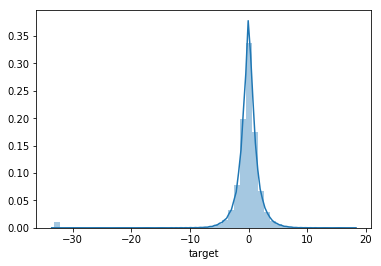

In [41]:
#plt.hist(trainDF.target)
sns.distplot(trainDF.target)
plt.show()

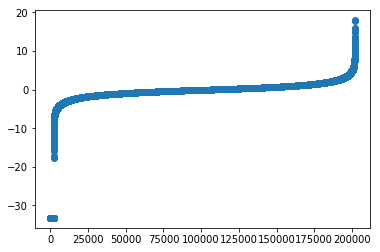

In [42]:
plt.scatter(x=range(trainDF.target.shape[0]), y=np.sort(trainDF.target.values))
plt.show()

#### Feature Engineering

In [43]:
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

In [44]:
histDF = binarize(histDF)

In [45]:
histDF = pd.get_dummies(histDF, columns=['category_2', 'category_3'])

In [46]:
histDF.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C,category_3_other
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0,0


In [47]:
aggfunc = {
    'category_1':['sum', 'mean'],
    'category_2_1.0': 'mean',
    'category_2_2.0': 'mean',
    'category_2_3.0': 'mean',
    'category_2_4.0': 'mean',
    'category_2_5.0': 'mean',
    'category_3_A': 'mean',
    'category_3_B': 'mean',
    'category_3_C': 'mean',
    'state_id': 'nunique',
    'city_id': 'nunique',
    'purchase_amount': ['sum', 'mean', 'count', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    ##'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': ['min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'card_id':['count']
}

In [48]:
agghistDF = histDF.groupby('card_id').aggregate(aggfunc)

In [49]:
agghistDF.columns = ['_'.join(col).strip() for col in agghistDF.columns.values]
agghistDF.columns

Index(['category_1_sum', 'category_1_mean', 'category_2_1.0_mean',
       'category_2_2.0_mean', 'category_2_3.0_mean', 'category_2_4.0_mean',
       'category_2_5.0_mean', 'category_3_A_mean', 'category_3_B_mean',
       'category_3_C_mean', 'state_id_nunique', 'city_id_nunique',
       'purchase_amount_sum', 'purchase_amount_mean', 'purchase_amount_count',
       'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_std',
       'installments_sum', 'installments_mean', 'installments_max',
       'installments_min', 'installments_std', 'purchase_date_min',
       'purchase_date_max', 'month_lag_mean', 'month_lag_max', 'month_lag_min',
       'month_lag_std', 'card_id_count'],
      dtype='object')

In [50]:
agghistDF.reset_index(inplace=True)

In [51]:
agghistDF.head()

,card_id,category_1_sum,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_3_A_mean,category_3_B_mean,category_3_C_mean,state_id_nunique,city_id_nunique,purchase_amount_sum,purchase_amount_mean,purchase_amount_count,purchase_amount_max,purchase_amount_min,purchase_amount_std,installments_sum,installments_mean,installments_max,installments_min,installments_std,purchase_date_min,purchase_date_max,month_lag_mean,month_lag_max,month_lag_min,month_lag_std,card_id_count
0,C_ID_00007093c1,28,0.187919,0.000000,0.000000,0.993289,0.0,0.006711,0.000000,0.838926,0.161074,3,4,-76.845039,-0.515739,149,1.507069,-0.728876,0.298141,192,1.288591,6,1,0.764900,2017-02-14 14:00:43,2018-02-27 05:14:57,-5.852349,0,-12,3.453114,149
1,C_ID_0001238066,2,0.016260,0.772358,0.000000,0.065041,0.0,0.162602,0.000000,0.715447,0.260163,6,18,-72.447197,-0.589002,123,0.768095,-0.734887,0.190235,198,1.609756,10,-1,1.485637,2017-09-28 22:25:14,2018-02-27 16:18:59,-1.813008,0,-5,1.288980,123
2,C_ID_0001506ef0,0,0.000000,0.030303,0.000000,0.969697,0.0,0.000000,0.984848,0.015152,0.000000,2,3,-34.601879,-0.524271,66,1.493545,-0.740491,0.472284,1,0.015152,1,0,0.123091,2017-01-14 16:16:01,2018-02-17 12:33:56,-4.833333,0,-13,4.237500,66
3,C_ID_0001793786,2,0.009259,0.050926,0.351852,0.597222,0.0,0.000000,0.976852,0.023148,0.000000,4,10,-36.786011,-0.170306,216,4.554145,-0.745405,0.836046,5,0.023148,1,0,0.150723,2017-01-21 10:15:21,2017-10-31 20:20:18,-3.328704,0,-9,2.306373,216
4,C_ID_000183fdda,4,0.027778,0.048611,0.006944,0.937500,0.0,0.006944,0.000000,0.715278,0.256944,7,9,-68.837936,-0.478041,144,2.764788,-0.737892,0.524948,264,1.833333,10,-1,2.118846,2017-08-07 09:49:14,2018-02-25 20:57:08,-2.451389,0,-6,1.895264,144


In [52]:
#histtransGroupby = histDF.groupby('card_id').size().reset_index(name='transactions_count')

In [53]:
#histtransGroupby.head()
#del histtransGroupby

In [54]:
newMerchDF = binarize(newMerchDF)

In [55]:
newMerchDF = pd.get_dummies(newMerchDF, columns=['category_2', 'category_3'])

In [56]:
aggnewMerchDF = newMerchDF.groupby('card_id').aggregate(aggfunc)

In [57]:
aggnewMerchDF.columns = ['_'.join(col).strip() for col in aggnewMerchDF.columns.values]
aggnewMerchDF.columns

Index(['category_1_sum', 'category_1_mean', 'category_2_1.0_mean',
       'category_2_2.0_mean', 'category_2_3.0_mean', 'category_2_4.0_mean',
       'category_2_5.0_mean', 'category_3_A_mean', 'category_3_B_mean',
       'category_3_C_mean', 'state_id_nunique', 'city_id_nunique',
       'purchase_amount_sum', 'purchase_amount_mean', 'purchase_amount_count',
       'purchase_amount_max', 'purchase_amount_min', 'purchase_amount_std',
       'installments_sum', 'installments_mean', 'installments_max',
       'installments_min', 'installments_std', 'purchase_date_min',
       'purchase_date_max', 'month_lag_mean', 'month_lag_max', 'month_lag_min',
       'month_lag_std', 'card_id_count'],
      dtype='object')

In [58]:
aggnewMerchDF.reset_index(inplace=True)

In [59]:
aggnewMerchDF.head()

,card_id,category_1_sum,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_3_A_mean,category_3_B_mean,category_3_C_mean,state_id_nunique,city_id_nunique,purchase_amount_sum,purchase_amount_mean,purchase_amount_count,purchase_amount_max,purchase_amount_min,purchase_amount_std,installments_sum,installments_mean,installments_max,installments_min,installments_std,purchase_date_min,purchase_date_max,month_lag_mean,month_lag_max,month_lag_min,month_lag_std,card_id_count
0,C_ID_00007093c1,0,0.000000,0.500000,0.000000,0.500000,0.0,0.000000,0.0,1.000000,0.000000,2,2,-1.328125,-0.664062,2,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,2018-04-03 11:13:35,2018-04-09 16:23:59,2.000000,2,2,0.000000,2
1,C_ID_0001238066,2,0.076923,0.769231,0.000000,0.115385,0.0,0.115385,0.0,0.807692,0.153846,4,8,-14.851562,-0.571289,26,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,2018-03-01 16:48:27,2018-04-30 19:57:30,1.346154,2,1,0.485165,26
2,C_ID_0001506ef0,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,1.0,0.000000,0.000000,1,1,-1.447266,-0.723633,2,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,2018-03-16 22:21:58,2018-03-22 09:14:30,1.000000,1,1,0.000000,2
3,C_ID_0001793786,0,0.000000,0.483871,0.258065,0.225806,0.0,0.032258,1.0,0.000000,0.000000,5,7,-0.229004,-0.007385,31,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,2017-11-15 15:44:20,2017-12-31 17:35:56,1.322581,2,1,0.475191,31
4,C_ID_000183fdda,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.545455,0.363636,2,2,-6.589844,-0.599121,11,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,2018-03-02 12:26:26,2018-04-30 14:59:53,1.272727,2,1,0.467099,11


#### Test Data

In [60]:
testDF = reduce_mem_usage(pd.read_csv(testFilePath)) # read test.csv file to a dataframe

Mem. usage decreased to  2.24 Mb (52.5% reduction)


In [61]:
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int8
feature_2             123623 non-null int8
feature_3             123623 non-null int8
dtypes: int8(3), object(2)
memory usage: 2.2+ MB


#### Merge Cells

In [62]:
#trainHistMergDF = trainDF.merge(histDF, on = 'card_id', how = 'left')
trainDF = pd.merge(trainDF, agghistDF, on = 'card_id', how = 'left')
trainDF = pd.merge(trainDF, newMerchDF, on = 'card_id', how = 'left')

In [63]:
testDF = pd.merge(testDF, agghistDF, on = 'card_id', how = 'left')
testDF = pd.merge(testDF, newMerchDF, on = 'card_id', how = 'left')

In [64]:
target = trainDF['target']

In [65]:
features = [c for c in trainDF.columns if c not in ['card_id', 'first_active_month', 'target', 'purchase_date_min', 
                                                    'purchase_date_max', 'merchant_id', 'purchase_date']]
categoricalFeatures = ['feature_2', 'feature_3']

In [66]:
n_estimators = [4, 8, 16, 32, 64, 100, 200]
max_depth = [4, 8, 10, 12, 16, 32, 64]
min_child_weight = [2, 4, 6, 8, 10, 12, 16, 32, 64]
gamma = [i/10.0 for i in range(0,5)]
colsample_bytree = [0.2, 0.4, 0.6, 0.8]
colsample_bylevel = [0.2, 0.4, 0.6, 0.8]
params_xgb = {'n_estimators': n_estimators, 
              'max_depth': max_depth, 
              'min_child_weight': min_child_weight, 
              'gamma': gamma, 
              'colsample_bytree': colsample_bytree, 
              'colsample_bylevel':colsample_bylevel}

In [67]:
xg_reg = xgb.XGBRegressor(objective = "reg:linear", silent=True, subsample=0.8, learning_rate=0.1, n_jobs=-1)

In [68]:
randomSearchCv = RandomizedSearchCV(xg_reg, param_distributions=params_xgb, cv=5, scoring='neg_mean_squared_error')

In [70]:
randomSearchCv.fit(trainDF[features].values, target.values)

C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in re

C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in re

C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in re

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [4, 8, 16, 32, 64, 100, 200], 'max_depth': [4, 8, 10, 12, 16, 32, 64], 'min_child_weight': [2, 4, 6, 8, 10, 12, 16, 32, 64], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.2, 0.4, 0.6, 0.8], 'colsample_bylevel': [0.2, 0.4, 0.6, 0.8]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          v

In [71]:

print("Best parameter is {} with score is {}".format(randomSearchCv.best_params_, randomSearchCv.best_score_))
print('Test data accuracy score with RandomSearchCV: {}'.format(randomSearchCv.score(trainDF[features].values,target.values)))

Best parameter is {'n_estimators': 64, 'min_child_weight': 32, 'max_depth': 32, 'gamma': 0.1, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.2} with score is -8.886892735963476
Test data accuracy score with RandomSearchCV: -7.622561931610107


C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [72]:
predictxg_reg_train = randomSearchCv.predict(trainDF[features].values)

In [73]:
print("CV score: {:<8.5f}".format(mean_squared_error(target, predictxg_reg_train)**0.5))

CV score: 2.76090 


C:\Users\Priyanka\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [74]:
featureImpList_xgb = randomSearchCv.best_estimator_.feature_importances_
featureImp_xgb = dict(zip(features, featureImpList_xgb.tolist()))

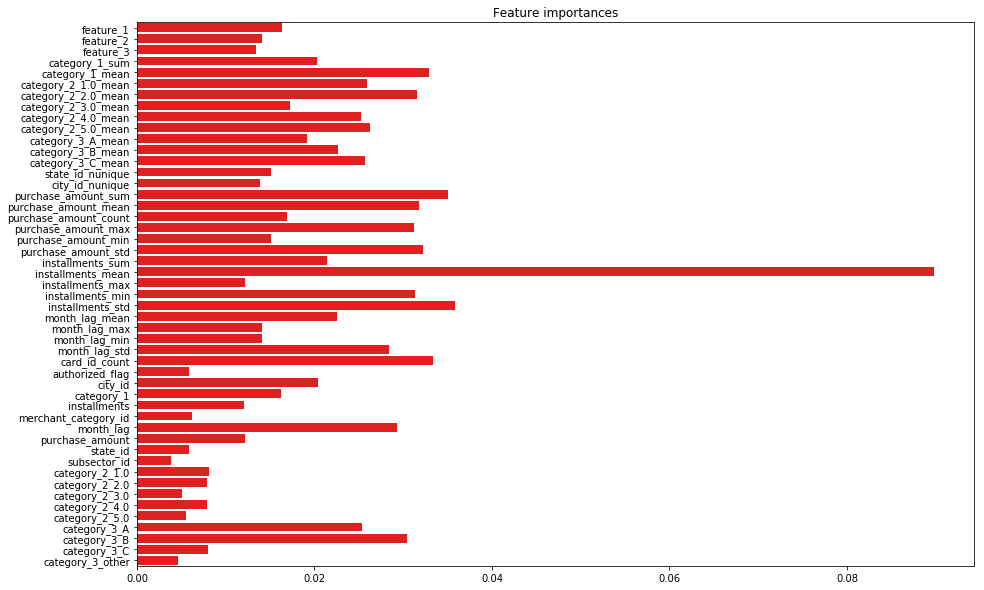

In [75]:
plt.subplots(figsize=(15,10))
plt.title("Feature importances")
ax = sns.barplot(list(featureImp_xgb.values()), list(featureImp_xgb.keys()), color='r')
plt.show()

In [76]:
predictxg_reg = randomSearchCv.predict(testDF[features].values)

In [77]:
subDF = pd.DataFrame({"card_id":testDF["card_id"].values})
subDF["target"] = predictxg_reg
subDF.to_csv("submit1.csv", index=False)